In [1]:
import fiona
import networkx as nx
import osmnx as ox
import shapely as shp
import json
import geopandas as gpd

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm

In [ ]:
new_train_df = new_all_df.sample(frac=0.9,random_state=42).reset_index(drop=True)
new_val_df   = new_all_df.drop(new_train_df.index).sample(frac=1.0, random_state=42).reset_index(drop=True)

In [ ]:
new_train_df

,image,has_road
0,/deep/group/aicc-bootcamp/transportation/data/...,no
1,/deep/group/aicc-bootcamp/transportation/data/...,no
2,/deep/group/aicc-bootcamp/transportation/data/...,no
3,/deep/group/aicc-bootcamp/transportation/data/...,no
4,/deep/group/aicc-bootcamp/transportation/data/...,no
...,...,...
10799,/deep/group/aicc-bootcamp/transportation/data/...,no
10800,/deep/group/aicc-bootcamp/transportation/data/...,yes
10801,/deep/group/aicc-bootcamp/transportation/data/...,no
10802,/deep/group/aicc-bootcamp/transportation/data/...,no


In [ ]:
new_train_df.has_road.value_counts()

no     9594
yes    1210
Name: has_road, dtype: int64

In [ ]:
new_val_df

,image,has_road
0,/deep/group/aicc-bootcamp/transportation/data/...,yes
1,/deep/group/aicc-bootcamp/transportation/data/...,yes
2,/deep/group/aicc-bootcamp/transportation/data/...,yes
3,/deep/group/aicc-bootcamp/transportation/data/...,yes
4,/deep/group/aicc-bootcamp/transportation/data/...,yes
...,...,...
1195,/deep/group/aicc-bootcamp/transportation/data/...,yes
1196,/deep/group/aicc-bootcamp/transportation/data/...,yes
1197,/deep/group/aicc-bootcamp/transportation/data/...,yes
1198,/deep/group/aicc-bootcamp/transportation/data/...,yes


In [ ]:
new_val_df.has_road.value_counts()

yes    1085
no      115
Name: has_road, dtype: int64

In [ ]:
new_train_df.to_csv('/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/train.csv')
new_val_df.to_csv('/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/val.csv')

In [4]:
OG_CSV_PATH = Path("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_negatives_combined.csv")
DVRPC_BOUNDARY_PATH = Path("/deep/u/ayushsn/aicc-spr22-transportation/preprocess/util_scripts/dvrpc_boundary.shp")
ALL_DRIVE = (
	f'["highway"]["area"!~"yes"]'
	f'["highway"!~"abandoned|bridleway|construction|corridor|cycleway|elevator|planned|escalator|'
	f'footway|path|pedestrian|platform|proposed|raceway|steps|track"]'
    f'["motor_vehicle"!~"no"]["motorcar"!~"no"]'
    f'["service"!~"parking|private"]'
)
dvrpc_boundary_gpd = gpd.read_file(DVRPC_BOUNDARY_PATH)
dvrpc_boundary = dvrpc_boundary_gpd.geometry[0]

In [5]:
G = ox.graph_from_polygon(dvrpc_boundary, custom_filter = ALL_DRIVE)

In [14]:
filepath = "/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/dvrpc_all_drive.graphml"
ox.save_graphml(G, filepath)

In [27]:
mislabeled_path = "/deep/group/aicc-bootcamp/transportation/data/dvrpc/aerial/imagery/500:0:0.1:18:-436:87865.json"

In [15]:
has_road_path = "/deep/group/aicc-bootcamp/transportation/data/dvrpc/aerial/imagery/500:0:0.1:18:-207:88892.json"

In [38]:
no_road_path = "/deep/group/aicc-bootcamp/transportation/data/dvrpc/aerial/imagery/500:0:0.1:18:-1027:88760.json"

In [39]:
with open(Path(no_road_path).with_suffix('.json')) as json_file:
    data = json.load(json_file)
no_road_polygon = shp.wkt.loads(str(data['extent']))

In [29]:
try:
    truncatedG = ox.truncate.truncate_graph_polygon(G, polygon, retain_all=True, truncate_by_edge=True)
    has_road = not nx.is_empty(truncatedG)
except ValueError:
    has_road = False

In [30]:
has_road

False

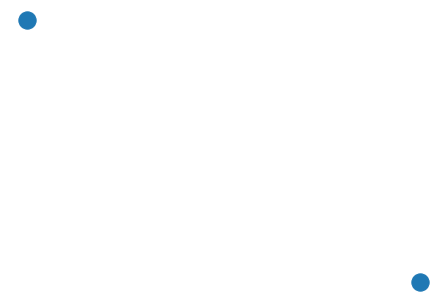

In [31]:
nx.draw(truncatedG)

In [55]:
def polygonize(x):
    with open(Path(x).with_suffix('.json')) as json_file:
        data = json.load(json_file)
    return shp.wkt.loads(str(data['extent']))

In [34]:
edges_gdf = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True,
                                     node_geometry=False, fill_edge_geometry=True)

In [48]:
edges_gdf

osmid  \
u           v           key                                         
103086216   103086219   0                                11561533   
            103159229   0                               866657549   
            103147792   0                               866657549   
103086219   103086222   0                                11561533   
            103086216   0                                11561533   
...                                                           ...   
10601421682 10601421683 0                              1137266247   
                        1                              1137266245   
10601421683 10601421661 0                              1137266245   
                        1    [1137266248, 1137266249, 1137266250]   
10603014471 8256251370  0                              1137456727   

                                       name      highway oneway   length  \
u           v           key                                                
103086216   103086219   0    Lincoln Street  residential  False  201.281   
            103159229   0       12th Street        trunk  False   50.835   
            103147792   0       12th Street        trunk  False   68.146   
103086219   103086222   0    Lincoln Street  residential  False  201.664   
            103086216   0    Lincoln Street  residential  False  201.281   
...                                     ...          ...    ...      ...   
10601421682 10601421683 0               NaN      service   True   38.199   
                        1               NaN      service   True   63.155   
10601421683 10601421661 0               NaN      service   True   45.835   
                        1               NaN      service  False   42.443   
10603014471 8256251370  0               NaN      service  False  294.311   

                            lanes    ref  \
u           v           key                
103086216   103086219   0     NaN    NaN   
            103159229   0       2  NJ 54   
            103147792   0       2  NJ 54   
103086219   103086222   0     NaN    NaN   
            103086216   0     NaN    NaN   
...                           ...    ...   
10601421682 10601421683 0     NaN    NaN   
                        1     NaN    NaN   
10601421683 10601421661 0     NaN    NaN   
                        1     NaN    NaN   
10603014471 8256251370  0     NaN    NaN   

                                                                      geometry  \
u           v           key                                                      
103086216   103086219   0    LINESTRING (-74.80657 39.63321, -74.80484 39.6...   
            103159229   0    LINESTRING (-74.80657 39.63321, -74.80618 39.6...   
            103147792   0    LINESTRING (-74.80657 39.63321, -74.80711 39.6...   
103086219   103086222   0    LINESTRING (-74.80484 39.63199, -74.80309 39.6...   
            103086216   0    LINESTRING (-74.80484 39.63199, -74.80657 39.6...   
...                                                                        ...   
10601421682 10601421683 0    LINESTRING (-75.99510 40.39041, -75.99466 40.3...   
                        1    LINESTRING (-75.99510 40.39041, -75.99511 40.3...   
10601421683 10601421661 0    LINESTRING (-75.99466 40.39036, -75.99455 40.3...   
                        1    LINESTRING (-75.99466 40.39036, -75.99463 40.3...   
10603014471 8256251370  0    LINESTRING (-75.87003 40.47275, -75.87137 40.4...   

                              service access maxspeed junction bridge tunnel  \
u           v           key                                                    
103086216   103086219   0         NaN    NaN      NaN      NaN    NaN    NaN   
            103159229   0         NaN    NaN      NaN      NaN    NaN    NaN   
            103147792   0         NaN    NaN      NaN      NaN    NaN    NaN   
103086219   103086222   0         NaN    NaN      NaN      NaN    NaN    NaN   
            103086216   0         NaN    NaN      NaN

In [61]:
edges_gdf.intersects(has_road_polygon).any()

True

In [62]:
edges_gdf.intersects(mislabeled_polygon).any()

True

In [60]:
edges_gdf.intersects(polygonize("/deep/group/aicc-bootcamp/transportation/data/dvrpc/aerial/imagery/500:0:0.1:18:-252:88773.png")).any()

True

In [59]:
edges_gdf.intersects(no_road_polygon).any()

False

In [63]:
ALL = "/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_examples_combined.csv"
POS = "/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_positives_combined.csv"
NEG = "/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_negatives_combined.csv"

In [67]:
def intersect_using_gdf(CSV):
    CSV = Path(CSV)
    has_roads = []
    image_paths = np.asarray(pd.read_csv(CSV, header=0).iloc[:, 1])
    to_label = {True: "yes", False: "no"}
    for idx, image_path in enumerate(tqdm(image_paths)):
        has_road = edges_gdf.intersects(polygonize(image_path)).any()
        has_roads.append(to_label[has_road])
    df = pd.DataFrame({"image": image_paths, "has_road": has_roads})
    df.to_csv(CSV.with_stem(f"{CSV.stem}_gdf"))

In [68]:
intersect_using_gdf(POS)

100%|██████████| 1363/1363 [02:24<00:00,  9.42it/s]


In [69]:
intersect_using_gdf(NEG)

100%|██████████| 10641/10641 [24:44<00:00,  7.17it/s]


In [70]:
intersect_using_gdf(ALL)

100%|██████████| 12004/12004 [21:15<00:00,  9.41it/s]


In [74]:
import torch
from torch import Tensor
from torchvision import transforms as T
import matplotlib.pyplot as plt
from flash.core.data.utilities.classification import SingleLabelTargetFormatter
from flash.image.classification.data import MatplotlibVisualization
from flash.core.utilities.imports import requires
from flash.core.data.callback import BaseDataFetcher
from typing import Any, Callable, Collection, Dict, List, Optional, Sequence, Tuple, Type, Union
from flash.image import ImageClassificationData, ImageClassifier
from flash.core.data.transforms import ApplyToKeys
from flash.core.data.io.input_transform import InputTransform
from flash.core.data.io.input import DataKeys
from dataclasses import dataclass

import sys
sys.path.append('../')
from torchdependencies import RoadDataset, make_weights_for_balanced_classes, pd_make_weights_for_balanced_classes

In [75]:
class CustomVisualization(MatplotlibVisualization):
    @requires("matplotlib")
    def _show_images_and_labels(
        self,
        data: List[Any],
        num_samples: int,
        title: str,
        limit_nb_samples: int = None,
        figsize: Tuple[int, int] = (6.4, 4.8),
    ):
        num_samples = max(1, min(num_samples, limit_nb_samples))

        # define the image grid
        cols: int = min(num_samples, self.max_cols)
        rows: int = num_samples // cols

        # create figure and set title
        fig, axs = plt.subplots(rows, cols, figsize=figsize)
        fig.suptitle(title)

        if not isinstance(axs, np.ndarray):
            axs = np.array(axs)
        axs = axs.flatten()

        for i, ax in enumerate(axs):
            # unpack images and labels
            if isinstance(data, list):
                _img, _label = data[i][DataKeys.INPUT], data[i].get(DataKeys.TARGET, "")
                _path = data[i][DataKeys.METADATA]['filepath']
            elif isinstance(data, dict):
                _img, _label = data[DataKeys.INPUT][i], data.get(DataKeys.TARGET, [""] * (i + 1))[i]
                _path = data[DataKeys.METADATA][i]['filepath']
            else:
                raise TypeError(f"Unknown data type. Got: {type(data)}.")
            # convert images to numpy
            _img: np.ndarray = self._to_numpy(_img)
            if isinstance(_label, Tensor):
                _label = _label.squeeze().tolist()
            # show image and set label as subplot title
            ax.imshow(_img)
            ax.set_title(str(_label) + " | " + Path(_path).stem)
            ax.axis("off")
        plt.show(block=self.block_viz_window)

class CustomImageClassificationData(ImageClassificationData):
    @staticmethod
    def configure_data_fetcher(*args, **kwargs) -> BaseDataFetcher:
        return CustomVisualization(*args, **kwargs)

In [76]:
@dataclass
class ImageClassificationInputTransform(InputTransform):
    image_size: Tuple[int, int] = (500, 500)
    mean: Union[float, Tuple[float, float, float]] = (0.4300, 0.3860, 0.3388)
    std:  Union[float, Tuple[float, float, float]] = (0.1870, 0.1533, 0.1267)

    def per_sample_transform(self):
        return T.Compose(
            [
                ApplyToKeys(
                    "input",
                    T.Compose([T.ToTensor(), T.Resize(self.image_size), T.Normalize(self.mean, self.std)]),
                ),
                ApplyToKeys("target", torch.as_tensor),
            ]
        )

In [79]:
ALL_GDFED = "/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_examples_combined_gdf.csv"
print(pd.read_csv(ALL_GDFED).has_road.value_counts())
weights, weight_per_class = pd_make_weights_for_balanced_classes(ALL_GDFED)
weights = torch.DoubleTensor(weights)
print(weights[:8])
print(weight_per_class)

no     7838
yes    4166
Name: has_road, dtype: int64
tensor([1.5315, 1.5315, 1.5315, 1.5315, 2.8814, 1.5315, 1.5315, 2.8814],
       dtype=torch.float64)
no     1.531513
yes    2.881421
Name: has_road, dtype: float64


In [80]:
train_dm = CustomImageClassificationData.from_csv(
    "image",
    "has_road",
    train_file=ALL_GDFED,
    target_formatter=SingleLabelTargetFormatter(labels=["no", "yes"]),
    transform=ImageClassificationInputTransform(),
    sampler=torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True),
    batch_size=8,
    num_workers=4
)

/deep/group/aicc-bootcamp/packages/miniconda3/envs/transportation/lib/python3.9/site-packages/pytorch_lightning/utilities/apply_func.py:31: LightningDeprecationWarning: `pytorch_lightning.utilities.apply_func.apply_to_collection` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_utilities.core.apply_func.apply_to_collection` instead.
  rank_zero_deprecation(


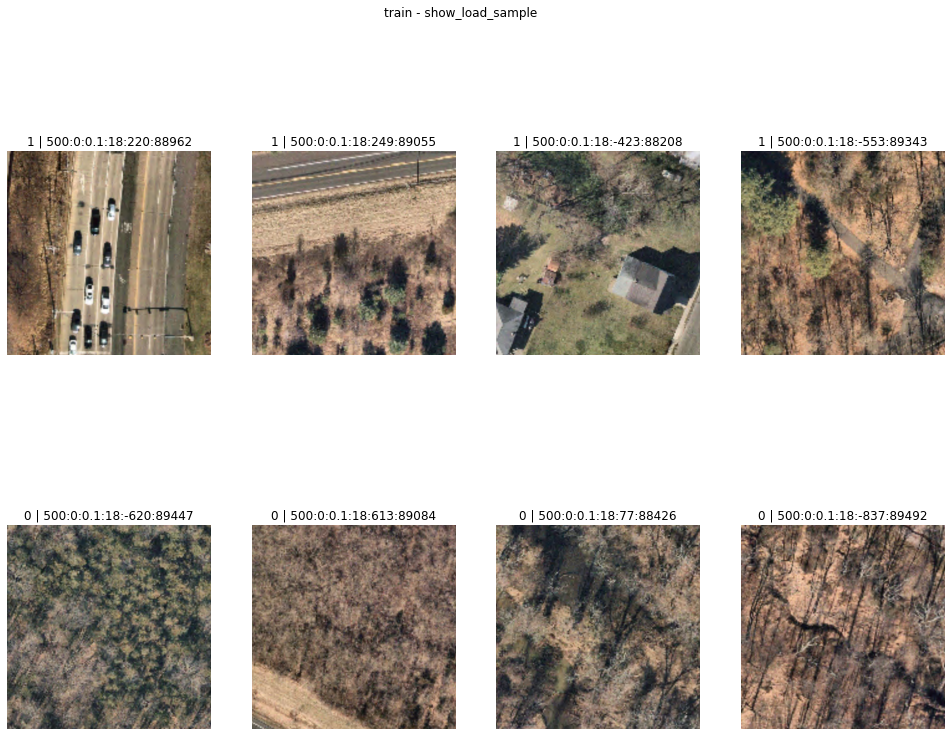

In [88]:
train_dm.show_train_batch(figsize=(16.8, 12.6))

In [1]:
import pandas as pd
new_all_df = pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_examples_combined_gdf.csv")

In [27]:
new_all_df.has_road.value_counts()

no     7838
yes    4166
Name: has_road, dtype: int64

In [28]:
new_train_df = new_all_df.sample(frac=0.9)
new_val_df   = new_all_df.drop(new_train_df.index).sample(frac=1.0)

In [37]:
new_train_df = new_train_df.drop(columns=new_train_df.columns[0]).reset_index(drop=True)
new_train_df

,image,has_road
0,/deep/group/aicc-bootcamp/transportation/data/...,no
1,/deep/group/aicc-bootcamp/transportation/data/...,no
2,/deep/group/aicc-bootcamp/transportation/data/...,no
3,/deep/group/aicc-bootcamp/transportation/data/...,no
4,/deep/group/aicc-bootcamp/transportation/data/...,no
...,...,...
10799,/deep/group/aicc-bootcamp/transportation/data/...,no
10800,/deep/group/aicc-bootcamp/transportation/data/...,yes
10801,/deep/group/aicc-bootcamp/transportation/data/...,yes
10802,/deep/group/aicc-bootcamp/transportation/data/...,no


In [38]:
new_train_df.has_road.value_counts()

no     7039
yes    3765
Name: has_road, dtype: int64

In [35]:
new_val_df = new_val_df.drop(columns=new_val_df.columns[0]).reset_index(drop=True)
new_val_df

,image,has_road
0,/deep/group/aicc-bootcamp/transportation/data/...,no
1,/deep/group/aicc-bootcamp/transportation/data/...,no
2,/deep/group/aicc-bootcamp/transportation/data/...,yes
3,/deep/group/aicc-bootcamp/transportation/data/...,no
4,/deep/group/aicc-bootcamp/transportation/data/...,yes
...,...,...
1195,/deep/group/aicc-bootcamp/transportation/data/...,no
1196,/deep/group/aicc-bootcamp/transportation/data/...,no
1197,/deep/group/aicc-bootcamp/transportation/data/...,no
1198,/deep/group/aicc-bootcamp/transportation/data/...,no


In [36]:
new_val_df.has_road.value_counts()

no     799
yes    401
Name: has_road, dtype: int64

In [39]:
new_train_df.to_csv('/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/train.csv')
new_val_df.to_csv('/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/val.csv')